In [35]:
import json
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import xml.dom.minidom
import re
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image

### Step 1: Generating xml

#### Step 1.1 Preprocess CSV file 

In [49]:

def preprocess_csv(input_file, output_file):
    """
    Processes the CSV file by mapping each of the timestep values to unique integers.

    Parameters:
    input_file (str): The path to the input CSV file. //Might update with systemn
    output_file (str): The path to the output preprocessed CSV file. //Chage this to store the csv somewhere else

    Returns:
    None
    """
    timestep_mapping = {} # Dictionary to map each timestep to a unique integer
    current_timestep = 0 
    
    with open(input_file, 'r') as file:
        csv_reader = csv.reader(file) # Read the CSV file
        rows = list(csv_reader) # Store the rows of the CSV in a list
    
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file) # Write to the output CSV file

        #Iterate through each row in the CSV file
        for row in rows:
            timestep = float(row[0]) # Extract the timestep value from the row
            
            if timestep not in timestep_mapping: # If the timestep is not already mapped
                timestep_mapping[timestep] = current_timestep # Map the timestep to the current current_timestep equal 
                current_timestep += 1  # Increment the current_timestep
            
            row[0] = str(timestep_mapping[timestep]) # Update the timestep value in the row
            csv_writer.writerow(row) 

# input and output CSV file paths
input_file = 'build/bin/output.csv'
output_file = 'preprocessed_output.csv'

# Preprocess the CSV file
preprocess_csv(input_file, output_file)
print(f"Preprocessed CSV file created: {output_file}")

Preprocessed CSV file created: preprocessed_output.csv


#### Step 1.2 Create Graphs list from Preprocessed CSV

In [ ]:
# # Load the preprocessed CSV file
# df = pd.read_csv('preprocessed_output.csv', header=None) #Header row doesnt exists
# df.columns = ['Timestep', 'chunkID', 'source', 'destination']

# # print(df.head) #Print the first 5 rows of the dataframe. Use for debugging

# # Assuming height and width of the mesh are known
# height = 3  # Adjust as necessary based on mesh structure
# width = 3   # Adjust as necessary based on mesh structure

# def add_all_nodes(G, height, width):
#     """
#     Adds all nodes to the graph G.

#     Parameters:
#     - G (networkx.Graph): The graph to which the nodes will be added.
#     - height (int): The height of the grid.
#     - width (int): The width of the grid.

#     Returns:
#     None
#     """
#     for i in range(height * width):  # Assuming node identifiers are from 0 to height*width-1
#         G.add_node(i) #in all the mesh, add nodes

# # Get unique timesteps
# timesteps = df['Timestep'].unique()

# graphs = []

# for timestep in timesteps:
#     timestep_data = df[df['Timestep'] == timestep] # slice the dataframes into t = 0, 1...N
#     print(timestep_data.head)
    
#     G = nx.DiGraph() #Create a directed graph
#     add_all_nodes(G, height, width)  # Add nodes for this timestep
    
#     # Directly use integer identifiers from the CSV
#     for _, row in timestep_data.iterrows(): #Iterate through the rows of the dataframe
#         source = row['source'] #Extract the source node
#         print('src = ',source) 
#         destination = row['destination'] #Extract the destination node
#         print('dst = ', destination)
#         chunkID = row['chunkID']    #Extract the chunkID
#         print('chunk = ', chunkID)
#         G.add_edge(source, destination, chunkID=chunkID) #Add these nodes as the edge to the graph
    
#     graphs.append(G) #Append this graph to the list of graphs

####  Step 1.3 Create data structure node_traffic from graphs list

In [66]:
# Normally you would load data from a file like so:
# df = pd.read_csv("path_to_your_file.csv")
# Load the preprocessed CSV file
df = pd.read_csv('preprocessed_output.csv', header=None) #Header row doesnt exists
df.columns = ['Timestep', 'chunkID', 'source', 'destination']

gpu_ids = np.unique(df['Timestep'])
num_time_steps = len(gpu_ids)
print(f'List of GPUS: {gpu_ids}')
print(f'Number of time steps: {num_time_steps}')

# Create graphs per timestep
graphs = {t: nx.DiGraph() for t in df['Timestep'].unique()}

# add all gpu_ids to graph
for t, graph in graphs.items():
    graph.add_nodes_from(gpu_ids)

# Populate each graph
for _, row in df.iterrows():
    graphs[row['Timestep']].add_edge(row['source'], row['destination'], label=row['chunkID'])

# Initialize node_traffic from all possible edges in the first graph
node_traffic = {}

first_graph = graphs[0]  # Assuming the first timestep graph is fully representative
for node in first_graph.nodes():
    
    node_traffic[node] = {}
    edge_counter = 0  # Reset counter for each node

    # Add thread blocks for all outgoing edges
    for target in first_graph.successors(node):
        node_traffic[node][(node, target)] = {
            'threadID': edge_counter,
            'records': [{'timestep': t, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0} for t in graphs.keys()]
        }
        edge_counter += 1

    # Add thread blocks for all incoming edges if not already added
    for source in first_graph.predecessors(node):
        if (source, node) not in node_traffic[node]:
            node_traffic[node][(source, node)] = {
                'threadID': edge_counter,
                'records': [{'timestep': t, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0} for t in graphs.keys()]
            }
            edge_counter += 1

# Populate the node_traffic with actual data from all timestep graphs
for t_index, graph in graphs.items():
    for source, destination, data in graph.edges(data=True):
        node_traffic[source][(source, destination)]['records'][t_index]['chunkID'] = data['label']
        node_traffic[source][(source, destination)]['records'][t_index]['type'] = 's'
        node_traffic[destination][(source, destination)]['records'][t_index]['chunkID'] = data['label']
        node_traffic[destination][(source, destination)]['records'][t_index]['type'] = 'r'

# Debug: Print out node_traffic for node 0 to see thread blocks
print("Node 0 Thread Blocks:")
for edge_key, tb_info in node_traffic[0].items():
    print(f"Edge {edge_key} with Thread ID {tb_info['threadID']}:")
    for record in tb_info['records']:
        print(record)

List of GPUS: [0 1 2 3 4 5 6 7]
Number of time steps: 8
Node 0 Thread Blocks:
Edge (0, 1) with Thread ID 0:
{'timestep': 0, 'chunkID': 9, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 1, 'chunkID': 0, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 2, 'chunkID': 6, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 3, 'chunkID': 12, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 4, 'chunkID': 3, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 5, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 6, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 7, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
Edge (0, 3) with Thread ID 1:
{'timestep': 0, 'chunkID': 9, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 1, 'chunkID': 0, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}
{'timestep': 2, 'chunkID'

In [ ]:
first_graph = graphs[0]  # Assuming the first timestep graph is fully representative
for node in first_graph.nodes():
    print(node)

In [56]:
from pprint import pprint
pprint(node_traffic)

{0: {(0, 1): {'records': [{'chunkID': 9,
                           'deps': -1,
                           'depsid': -1,
                           'hasdeps': 0,
                           'timestep': 0,
                           'type': 's'},
                          {'chunkID': 0,
                           'deps': -1,
                           'depsid': -1,
                           'hasdeps': 0,
                           'timestep': 1,
                           'type': 's'},
                          {'chunkID': 6,
                           'deps': -1,
                           'depsid': -1,
                           'hasdeps': 0,
                           'timestep': 2,
                           'type': 's'},
                          {'chunkID': 12,
                           'deps': -1,
                           'depsid': -1,
                           'hasdeps': 0,
                           'timestep': 3,
                           'type': 's'},
                   

In [57]:
def pretty_print_node_traffic(data, indent=0):
    for node, edges in data.items():
        print('    ' * indent + str(node) + ':')
        if isinstance(edges, dict):
            pretty_print_node_traffic(edges, indent + 1)
        else:
            print('    ' * (indent + 1) + str(edges))

pretty_print_node_traffic(node_traffic)


0:
    (0, 1):
        threadID:
            0
        records:
            [{'timestep': 0, 'chunkID': 9, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 1, 'chunkID': 0, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 2, 'chunkID': 6, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 3, 'chunkID': 12, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 4, 'chunkID': 3, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 5, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 6, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 7, 'chunkID': -1, 'type': '-1', 'deps': -1, 'depsid': -1, 'hasdeps': 0}]
    (0, 3):
        threadID:
            1
        records:
            [{'timestep': 0, 'chunkID': 9, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'timestep': 1, 'chunkID': 0, 'type': 's', 'deps': -1, 'depsid': -1, 'hasdeps': 0}, {'

#### Step 1.4 Generate XML from data structure node_traffic & dump in XML file

In [67]:
def parse_output_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        # Using regular expressions to find the desired pattern
        pattern = r'\[All-Reduce Information\]\s*#Chunks/NPU:\s*(\d+)'
        num_chunks = r'\[2D Mesh Information\]\s*#NPUs:\s*(\d+)'
        match_chunks_per_npu, match_num_chunks = re.search(pattern, content), re.search(num_chunks, content)
        if match_chunks_per_npu and match_num_chunks:
            # Extracting the value of #Chunks/NPU
            chunks_per_npu, chunks_num = int(match_chunks_per_npu.group(1)), int(match_num_chunks.group(1))
            return chunks_per_npu, chunks_num
        else:
            # If the pattern is not found
            return None, None

# Example usage:
file_path = "./TACOS_output.txt" # path to the file (from ./run.sh)
chunks_per_npu, num_chunks = parse_output_file(file_path)
if chunks_per_npu is not None:
    print("Chunks/NPU:", chunks_per_npu)
    print(f"Number of chunks = {num_chunks}")

# Function to generate and save XML in a pretty format
def generate_and_save_xml_pretty(node_traffic, filename, chunks_per_npu, num_chunks):

    root = ET.Element("network")
    

    # Create <gpu> tags for each node
    for node, edges in sorted(node_traffic.items()):
        gpu_elem = ET.SubElement(root, "gpu", id=str(node), i_chunks="0", o_chunks=str(num_chunks), s_chunks="0")


        # Create <tb> tags for each connected edge
        for (source, destination), edge_info in edges.items():
            tb_elem = ET.SubElement(gpu_elem, "tb", id=str(edge_info['threadID']),
                                    send=str(destination if edge_info['records'][0]['type'] == 's' else '-1'),
                                    recv=str(source if edge_info['records'][0]['type'] == 'r' else '-1'),
                                    chan ="0")
            
            # create <step> tags for each time step
            for record in edge_info['records']:
                if(record['type'] != '-1'):
                    ET.SubElement(tb_elem, "step", s=str(record['timestep']), type=record['type'], srcbuf="o", srcoff=str(record['chunkID']), dstbuf="o", dstoff=str(record['chunkID']), cnt= str(chunks_per_npu), deps=str(record['deps']), depsid=str(record['depsid']), hasdeps=str(record['hasdeps']))


    # Convert to string using ElementTree and parse with minidom for pretty printing
    rough_string = ET.tostring(root, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    pretty_xml_as_string = reparsed.toprettyxml(indent="  ")

    # Write to file
    with open(filename, 'w') as file:
        file.write(pretty_xml_as_string)

Chunks/NPU: 2
Number of chunks = 9


In [68]:
# Usage
filename = 'network_flow_pretty.xml'
generate_and_save_xml_pretty(node_traffic, filename, chunks_per_npu, num_chunks)
print(f"XML file saved as {filename}")

XML file saved as network_flow_pretty.xml


### Visualize all time step graphs

In [69]:
def visualize_graph(G, name, t):
    print('Inside visual Graph = ',t)
    # Set positions for a 3x3 grid with more spacing
    pos = {
        0: "0,4!",
        1: "2,4!",
        2: "4,4!",
        3: "0,2!",
        4: "2,2!",
        5: "4,2!",
        6: "0,0!",
        7: "2,0!",
        8: "4,0!"
    }

    # Method 2: Visualize using Graphviz with fixed node positions
    A = to_agraph(G)

    # Set the fixed positions for each node
    for node, position in pos.items():
        A.get_node(node).attr['pos'] = position

    A.node_attr['shape'] = 'square'
    A.node_attr['style'] = 'filled'
    A.node_attr['fillcolor'] = 'skyblue'
    A.node_attr['fontcolor'] = 'black'
    A.edge_attr['fontsize'] = '10'
    A.layout(prog='fdp', args='-n') 

    # Corrected the graphviz_path as mentioned earlier (#3)
    graphviz_path = f'data/output_{name}.png'  # Make sure to use a valid path where the file can be saved

    A.draw(graphviz_path)  # Saving to output file for display
    Image(graphviz_path)

In [70]:
for t, graph in graphs.items():
    print(t)
    name = f'graph_{t}'
    visualize_graph(graph, name=name, t=t)

0
Inside visual Graph =  0
1
Inside visual Graph =  1
2
Inside visual Graph =  2
3
Inside visual Graph =  3
4
Inside visual Graph =  4
5
Inside visual Graph =  5
6
Inside visual Graph =  6
7
Inside visual Graph =  7


./data/output_graph_0.png


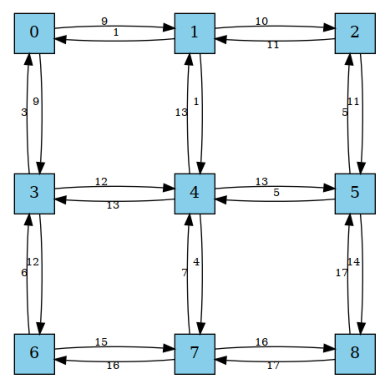

./data/output_graph_1.png


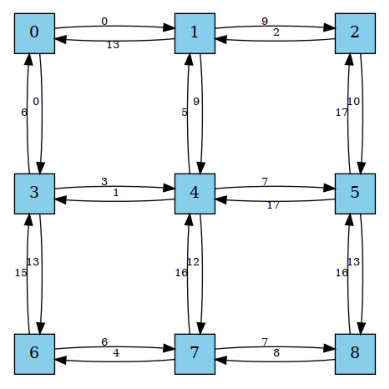

./data/output_graph_2.png


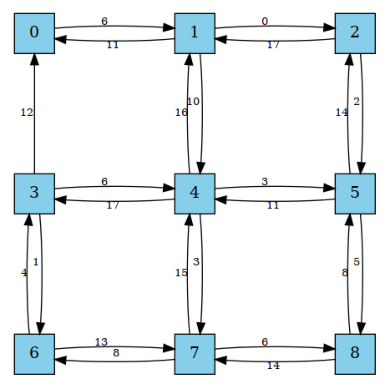

./data/output_graph_3.png


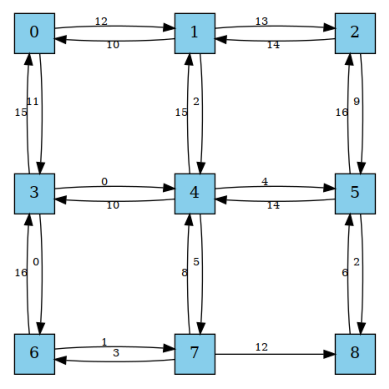

./data/output_graph_4.png


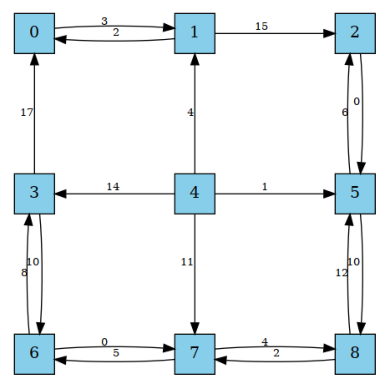

./data/output_graph_5.png


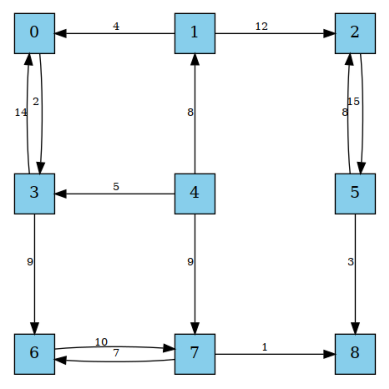

./data/output_graph_6.png


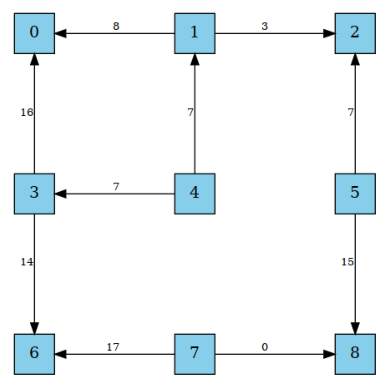

./data/output_graph_7.png


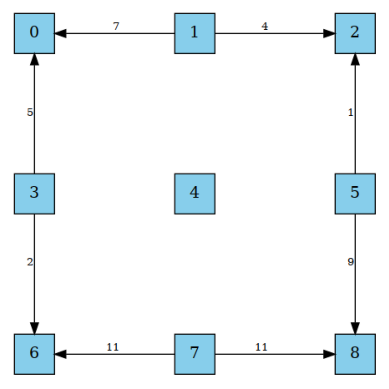

In [84]:
import matplotlib.image as mpimg
import os

path = './data'

dir = sorted(os.listdir(path))

for file in dir:
    f = os.path.join(path, file)
    print(os.path.join(path, file))
    img = mpimg.imread(f)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [63]:
graphs[7]

In [64]:
first_graph = graphs[6]  # Assuming the first timestep graph is fully representative
for node in first_graph.nodes():
    print(node)

0
1
2
3
4
5
6
7
8
